# Group Splitter (Standardized)

Refactored splitter that mirrors the `classify_groups` workflow:
- Reuses `graph_data` utilities for consistent node features and edge construction.
- Targets per-hit labels (pion, muon, pion+muon) with a cross-entropy objective.
- Prints per-class metrics and confusion matrices after every epoch.


In [1]:
import sys, os

PROJECT_ROOT = "/mnt/c/Users/obbee/research/notebooks/ML"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
    os.environ["PYTHONPATH"] = PROJECT_ROOT + os.pathsep + os.environ.get("PYTHONPATH", "")


In [2]:
import math
import glob
import re
from pathlib import Path
from typing import List, Dict, Any, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch_geometric.loader import DataLoader

from graph_data.utils import fully_connected_edge_index, build_edge_attr, SplitterGraphDataset, GraphRecord
from graph_data.models import GroupSplitter

from torch_geometric.data import Data


In [ ]:
_CHUNK_INDEX_RE = re.compile(r"_(\d+)\.npy$")

PION_MASK = 0b00001
MUON_MASK = 0b00010
POSITRON_MASK = 0b00100
ELECTRON_MASK = 0b01000
OTHER_MASK = 0b10000

NUM_NODE_CLASSES = 3  # channels: [pion, muon, mip]
NODE_LABEL_TO_NAME = {0: "pion", 1: "muon", 2: "mip"}

PI_IDX, MU_IDX, MIP_IDX = 0, 1, 2

PAIR_TYPES = ["pi-mu", "mu-mip", "pi-mip"]

PAIR_SPECIES = {
    "pi-mu":  (PI_IDX, MU_IDX),
    "mu-mip": (MU_IDX, MIP_IDX),
    "pi-mip": (PI_IDX, MIP_IDX),
}

PAIR_CLASS_NAMES = {
    "pi-mu":  ["pion", "muon", "pion+muon"],
    "mu-mip": ["muon", "mip", "muon+mip"],
    "pi-mip": ["pion", "mip", "pion+mip"],
}

GROUP_TYPE_INDEX = {
    "pi-mu":  0,
    "mu-mip": 1,
    "pi-mip": 2,
}

In [ ]:
def _extract_file_index(path: Path) -> Optional[int]:
    match = _CHUNK_INDEX_RE.search(path.name)
    return int(match.group(1)) if match else None


def _multilabel_from_mask(mask: int) -> Optional[List[int]]:
    """Return [is_pion, is_muon, is_mip] as ints 0/1, or None to drop hit."""
    has_pion = bool(mask & PION_MASK)
    has_muon = bool(mask & MUON_MASK)
    has_pos  = bool(mask & POSITRON_MASK)
    has_ele  = bool(mask & ELECTRON_MASK)

    has_mip = has_pos or has_ele

    # Drop pure OTHER hits: no pion/muon/e± content at all
    if not (has_pion or has_muon or has_mip):
        return None

    return [
        int(has_pion),
        int(has_muon),
        int(has_mip),
    ]

def is_multispecies_group(node_labels: np.ndarray) -> bool:
    """
    node_labels: [N, 3] array of 0/1 for [pion, muon, mip].
    Returns True if the group contains >= 2 particle species.
    """
    species_present = node_labels.sum(axis=0) > 0  # boolean array of shape [3]
    num_species = species_present.sum()
    return num_species >= 2


def load_splitter_groups(
    file_pattern: str,
    *,
    max_files: Optional[int] = None,
    limit_groups: Optional[int] = None,
    min_hits: int = 3,
    verbose: bool = True,
) -> List[Dict[str, Any]]:
    paths = [Path(p) for p in glob.glob(file_pattern)]
    if not paths:
        raise FileNotFoundError(f"No files matched pattern '{file_pattern}'")
    paths.sort(key=lambda p: (_extract_file_index(p) if _extract_file_index(p) is not None else math.inf, p.name))
    if max_files is not None:
        paths = paths[:max_files]

    records: List[Dict[str, Any]] = []
    # per-channel totals: [pion_hits, muon_hits, mip_hits]
    label_totals = np.zeros(3, dtype=int)

    for path in paths:
        if limit_groups is not None and len(records) >= limit_groups:
            break
        chunk = np.load(path, allow_pickle=True)
        chunk_index = _extract_file_index(path) or 0

        for event_offset, event_groups in enumerate(chunk):
            if limit_groups is not None and len(records) >= limit_groups:
                break
            if event_groups is None or len(event_groups) == 0:
                continue

            for group_idx, raw_group in enumerate(event_groups):
                if limit_groups is not None and len(records) >= limit_groups:
                    break
                group = np.asarray(raw_group)
                if group.ndim != 2 or group.shape[0] < min_hits or group.shape[1] < 6:
                    continue

                mask_values = group[:, 5].astype(int)
                node_labels: List[List[int]] = []
                keep_indices: List[int] = []

                for hit_idx, mask in enumerate(mask_values):
                    bits = _multilabel_from_mask(mask)
                    if bits is None:
                        continue  # pure OTHER
                    keep_indices.append(hit_idx)
                    node_labels.append(bits)
                    label_totals += np.array(bits, dtype=int)

                if len(node_labels) < 1:
                    continue  # need at least two labelled hits to form a graph

                if not is_multispecies_group(np.array(node_labels)): # skip single-species groups for training
                    continue

                filtered = group[keep_indices]
                coord = filtered[:, 0].astype(np.float32)
                z_pos = filtered[:, 1].astype(np.float32)
                view_flag = filtered[:, 2].astype(np.float32)
                energy = filtered[:, 3].astype(np.float32)

                record_event_id: Optional[int] = None
                if filtered.shape[1] > 6:
                    try:
                        record_event_id = int(filtered[0, 6])
                    except (ValueError, TypeError):
                        record_event_id = None
                if record_event_id is None:
                    record_event_id = chunk_index * 100000 + event_offset

                records.append({
                    'coord': coord,
                    'z': z_pos,
                    'view': view_flag,
                    'energy': energy,
                    # shape [num_hits, 3]
                    'hit_labels': node_labels,
                    'event_id': record_event_id,
                    'group_id': len(records),
                })

    if not records:
        raise ValueError('No labelled splitter groups found; adjust filtering thresholds.')

    if verbose:
        total_hits = label_totals.sum()
        pion_hits, muon_hits, mip_hits = label_totals.tolist()
        print(
            f"Loaded {len(records)} splitter groups from {len(paths)} files; "
            f"pion_hits={pion_hits}, muon_hits={muon_hits}, mip_hits={mip_hits}, total_hits={total_hits}"
        )

    return records


In [ ]:
def build_splitter_dataset(
    groups: list[dict],
    *,
    use_group_probs: bool = False,
) -> SplitterGraphDataset:
    """
    Build a SplitterGraphDataset from a list of group dicts.

    Expected keys in each group dict:
      - 'coord', 'z', 'energy', 'view' : per-hit arrays
      - per-hit labels under *either* 'hit_labels' or 'node_labels':
            shape [N, 3] -> [is_pion, is_muon, is_mip]
      - optional: 'event_id', 'group_id'
      - optional (if use_group_probs=True): 'group_probs' as [p_pi, p_mu, p_mip]
    """
    records: list[GraphRecord] = []
    for g in groups:
        # accept either 'hit_labels' or 'node_labels'
        labels_arr = g.get("hit_labels")
        if labels_arr is None:
            labels_arr = g.get("node_labels")

        rec = GraphRecord(
            coord=g["coord"],
            z=g["z"],
            energy=g["energy"],
            view=g["view"],
            labels=g.get("labels"),
            event_id=g.get("event_id"),
            group_id=g.get("group_id"),
            hit_labels=labels_arr,            
            group_probs=g.get("group_probs"),  # optional
        )
        records.append(rec)

    return SplitterGraphDataset(records, use_group_probs=use_group_probs)


def _split_records(records: List[Dict[str, Any]], train_fraction: float, seed: int):
    if len(records) <= 1:
        return list(records), []
    rng = np.random.default_rng(seed)
    indices = rng.permutation(len(records))
    train_size = max(1, int(len(records) * train_fraction))
    if train_size >= len(records):
        train_size = len(records) - 1
    train_idx = indices[:train_size]
    val_idx = indices[train_size:]
    return [records[i] for i in train_idx], [records[i] for i in val_idx]


def _get_hit_labels_array(record: Dict[str, Any]) -> np.ndarray:
    """
    Return per-hit labels as a [N, 3] array of ints.

    Accepts:
      - record["hit_labels"]  (new splitter-style key), or
    """
    if "hit_labels" in record and record["hit_labels"] is not None:
        labels = np.asarray(record["hit_labels"], dtype=int)
    else:
        raise KeyError("Record has neither 'hit_labels' nor 'node_labels'.")

    if labels.ndim != 2 or labels.shape[1] != NUM_NODE_CLASSES:
        raise ValueError(
            f"Per-hit labels must have shape [N, {NUM_NODE_CLASSES}], got {labels.shape}"
        )
    return labels

def _node_label_frequency(records: List[Dict[str, Any]]) -> np.ndarray:
    """
    Count positives per channel over all hits in these records.
    """
    counts = np.zeros(NUM_NODE_CLASSES, dtype=int)
    for record in records:
        labels = _get_hit_labels_array(record)  # [N, 3]
        counts += labels.sum(axis=0)
    return counts


def _make_loaders(
    records: List[Dict[str, Any]],
    *,
    train_fraction: float,
    batch_size: int,
    seed: int,
    use_group_probs: bool = False,
):
    train_records, val_records = _split_records(records, train_fraction, seed)

    train_dataset = build_splitter_dataset(train_records, use_group_probs=use_group_probs)
    val_dataset   = build_splitter_dataset(val_records,   use_group_probs=use_group_probs) if val_records else None

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False) if val_dataset else None

    return train_loader, val_loader, train_records, val_records


In [ ]:
def _init_confusion() -> np.ndarray:
    n_pairs = len(PAIR_TYPES)  # 3: "pi-mu", "mu-mip", "pi-mip"
    n_cls = 3                  # A only, B only, A+B
    return np.zeros((n_pairs, n_cls, n_cls), dtype=np.int64)

def _pair_class(bits: np.ndarray, idx_a: int, idx_b: int) -> Optional[int]:
    """
    bits: [3] array of 0/1 for [pi, mu, mip].
    idx_a, idx_b: which entries correspond to species A and B.
    Returns:
      0 -> A only
      1 -> B only
      2 -> A+B
      None -> ignore this hit for confusion (neither A nor B).
    """
    a = int(bits[idx_a])
    b = int(bits[idx_b])

    if a == 1 and b == 0:
        return 0
    elif a == 0 and b == 1:
        return 1
    elif a == 1 and b == 1:
        return 2
    else:
        return None  # (0,0) or irrelevant for this pair

def update_confusion_for_group(confusion, truth_labels, pred_labels):
    # Determine group type
    has_pi  = truth_labels[:, 0].any()
    has_mu  = truth_labels[:, 1].any()
    has_mip = truth_labels[:, 2].any()

    if has_pi and has_mu and not has_mip:
        gtype = "pi-mu"
    elif has_mu and has_mip and not has_pi:
        gtype = "mu-mip"
    elif has_pi and has_mip and not has_mu:
        gtype = "pi-mip"
    else:
        return  # skip for confusion

    gidx = GROUP_TYPE_INDEX[gtype]
    idx_a, idx_b = PAIR_SPECIES[gtype]

    for t_bits, p_bits in zip(truth_labels, pred_labels):
        t_cls = _pair_class(t_bits, idx_a, idx_b)
        p_cls = _pair_class(p_bits, idx_a, idx_b)
        if t_cls is None or p_cls is None:
            continue
        confusion[gidx, t_cls, p_cls] += 1


def _normalized(confusion: np.ndarray) -> np.ndarray:
    # Sum over prediction axis (axis=2)
    row_sums = confusion.sum(axis=2, keepdims=True)

    with np.errstate(divide='ignore', invalid='ignore'):
        normalized = np.divide(
            confusion,
            row_sums,
            out=np.zeros_like(confusion, dtype=float),
            where=row_sums != 0,
        )

    return normalized


def _plot_confusion(title: str, confusion: np.ndarray, epoch: int) -> np.ndarray:
    """
    confusion: [3 pair types, 3 truth classes, 3 pred classes]
    """
    fig, axes = plt.subplots(1, 3, figsize=(12, 3.5), squeeze=False)
    fig.suptitle(f"{title} hit-level confusion — epoch {epoch}")

    normalized = np.zeros_like(confusion, dtype=float)

    for gi, pair_name in enumerate(PAIR_TYPES):
        mat = confusion[gi]  # [3,3]
        row_sums = mat.sum(axis=1, keepdims=True)
        with np.errstate(divide='ignore', invalid='ignore'):
            norm = np.divide(
                mat,
                row_sums,
                out=np.zeros_like(mat, dtype=float),
                where=row_sums != 0,
            )
        normalized[gi] = norm

        ax = axes[0, gi]
        im = ax.imshow(norm, cmap='Blues', vmin=0.0, vmax=1.0)
        cls_names = PAIR_CLASS_NAMES[pair_name]
        ax.set_title(pair_name)
        ax.set_xticks(range(3))
        ax.set_yticks(range(3))
        ax.set_xticklabels(cls_names, rotation=30, ha='right')
        ax.set_yticklabels(cls_names)

        for i in range(3):
            for j in range(3):
                val = norm[i, j]
                count = mat[i, j]
                color = 'white' if val > 0.6 else 'black'
                ax.text(j, i, f"{val:.3f}\n({count:d})", ha='center', va='center', color=color, fontsize=8)

    fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
    #plt.tight_layout()
    plt.show()
    return normalized


def _run_train_epoch(model, loader, criterion, optimizer, device, grad_clip, threshold=0.5):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0
    confusion = _init_confusion()

    for batch in loader:
        batch = batch.to(device)
        logits = model(batch)   # [total_nodes, 3]
        targets = batch.y       # [total_nodes, 3]

        loss = criterion(logits, targets)

        optimizer.zero_grad()
        loss.backward()
        if grad_clip is not None:
            clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        with torch.no_grad():
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).float()   # [total_nodes, 3]

            # per-hit exact match accuracy
            correct = (preds == targets).all(dim=1).sum().item()
            total_correct += correct
            total_examples += targets.size(0)
            total_loss += loss.item() * targets.size(0)

            # --- per-hit confusion over pair types ---
            offset = 0
            for graph in batch.to_data_list():
                num_hits = graph.num_nodes
                t_slice = targets[offset:offset + num_hits].cpu().numpy()
                p_slice = preds[offset:offset + num_hits].cpu().numpy()
                update_confusion_for_group(confusion, t_slice, p_slice)
                offset += num_hits

    avg_loss = total_loss / max(total_examples, 1)
    avg_acc = total_correct / max(total_examples, 1)
    return avg_loss, avg_acc, confusion


def _run_eval_epoch(model, loader, criterion, device, threshold=0.5):
    if loader is None:
        return float('nan'), float('nan'), None

    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0
    confusion = _init_confusion()

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            logits = model(batch)
            targets = batch.y

            loss = criterion(logits, targets)

            probs = torch.sigmoid(logits)
            preds = (probs > threshold).float()

            correct = (preds == targets).all(dim=1).sum().item()
            total_correct += correct
            total_examples += targets.size(0)
            total_loss += loss.item() * targets.size(0)

            offset = 0
            for graph in batch.to_data_list():
                num_hits = graph.num_nodes
                t_slice = targets[offset:offset + num_hits].cpu().numpy()
                p_slice = preds[offset:offset + num_hits].cpu().numpy()
                update_confusion_for_group(confusion, t_slice, p_slice)
                offset += num_hits

    if total_examples == 0:
        return float('nan'), float('nan'), None

    avg_loss = total_loss / total_examples
    avg_acc = total_correct / total_examples
    return avg_loss, avg_acc, confusion

def train_group_splitter(
    records: List[Dict[str, Any]],
    *,
    model: Optional[GroupSplitter] = None,
    batch_size: int = 8,
    epochs: int = 30,
    lr: float = 1e-3,
    weight_decay: float = 1e-4,
    train_fraction: float = 0.85,
    seed: int = 42,
    device: Optional[str] = None,
    grad_clip: Optional[float] = None,
    scheduler_step_size: Optional[int] = 10,
    scheduler_gamma: float = 0.5,

    # NEW FLAG WE ADD:
    use_group_probs: bool = False,
):
    """
    Trains the multi-label splitter.

    New argument:
        use_group_probs: bool
            If True, the dataset builder will add classifier probabilities
            ([p_pi, p_mu, p_mip]) to each graph's node features.
    """

    if not records:
        raise ValueError("No records provided for training.")

    device_obj = torch.device(device or ("cuda" if torch.cuda.is_available() else "cpu"))
    model = model or GroupSplitter()
    model.to(device_obj)

    # --- UPDATED: forward use_group_probs into loaders ---
    train_loader, val_loader, train_records, val_records = _make_loaders(
        records,
        train_fraction=train_fraction,
        batch_size=batch_size,
        seed=seed,
        use_group_probs=use_group_probs,
    )

    # Compute per-channel positive counts (for BCE pos_weight)
    train_pos_counts = _node_label_frequency(train_records)
    total_train_hits = sum(_get_hit_labels_array(r).shape[0] for r in train_records)

    neg_counts = total_train_hits - train_pos_counts
    pos_weight = neg_counts / np.maximum(train_pos_counts, 1)
    pos_weight_t = torch.tensor(pos_weight, dtype=torch.float32, device=device_obj)
    pos_weight_r = torch.tensor([1,2,3], dtype=torch.float32, device=device_obj)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_r)
    #criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_t)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = None
    if scheduler_step_size and scheduler_step_size > 0:
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma
        )

    history = []

    for epoch in range(1, epochs + 1):
        current_lr = optimizer.param_groups[0]["lr"]

        train_loss, train_acc, train_conf = _run_train_epoch(
            model, train_loader, criterion, optimizer, device_obj, grad_clip
        )

        val_loss, val_acc, val_conf = _run_eval_epoch(
            model, val_loader, criterion, device_obj
        )

        if scheduler is not None:
            scheduler.step()

        # --- print info ---
        if not np.isnan(val_loss):
            print(
                f"Epoch {epoch:02d} | lr={current_lr:.5f} | "
                f"train_loss={train_loss:.5f} acc={train_acc:.5f} | "
                f"val_loss={val_loss:.5f} acc={val_acc:.5f}"
            )
        else:
            print(
                f"Epoch {epoch:02d} | lr={current_lr:.5f} | "
                f"train_loss={train_loss:.5f} acc={train_acc:.5f}"
            )

        train_norm = _plot_confusion("Train", train_conf, epoch)
        val_norm = None
        if val_conf is not None:
            val_norm = _plot_confusion("Val", val_conf, epoch)

        history.append({
            "epoch": epoch,
            "lr": float(current_lr),
            "train_loss": float(train_loss),
            "train_accuracy": float(train_acc),
            "train_confusion": train_conf.tolist(),
            "train_normalized": train_norm.tolist(),
            "val_loss": None if np.isnan(val_loss) else float(val_loss),
            "val_accuracy": None if np.isnan(val_acc) else float(val_acc),
            "val_confusion": None if val_conf is None else val_conf.tolist(),
            "val_normalized": None if val_norm is None else val_norm.tolist(),
        })

    return {
        "model": model,
        "history": history,
        "train_pos_counts": train_pos_counts.astype(int).tolist(),
        "total_train_hits": int(total_train_hits),
        "pos_weight": pos_weight.tolist(),
    }


Loaded 15602 splitter groups from 20 files; pion_hits=5683104, muon_hits=1222298, mip_hits=7714121, total_hits=14619523
Epoch 01 | lr=0.00100 | train_loss=0.11356 acc=0.90144 | val_loss=0.10349 acc=0.91113


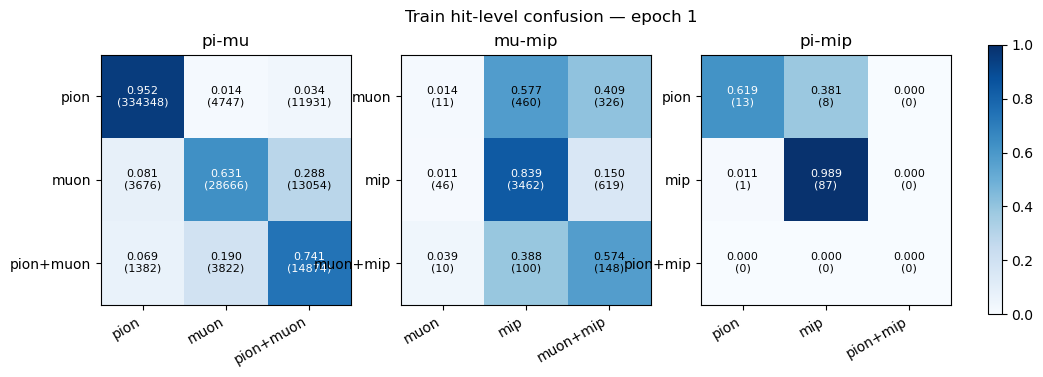

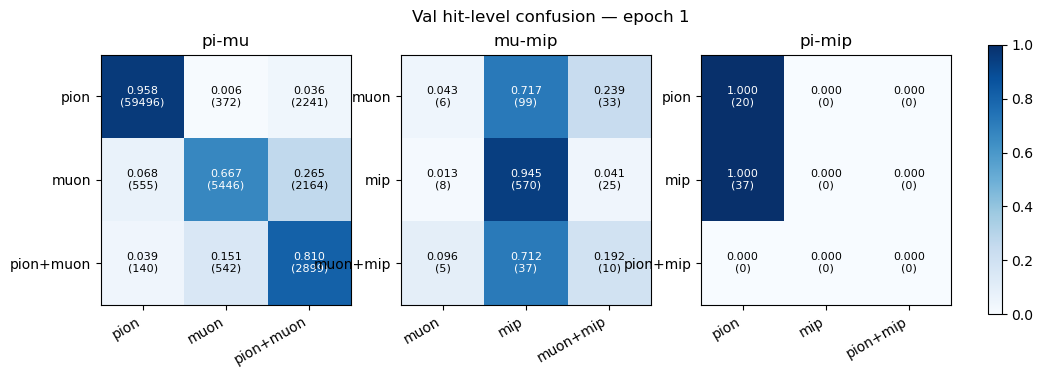

Epoch 02 | lr=0.00100 | train_loss=0.08387 acc=0.92753 | val_loss=0.09017 acc=0.93512


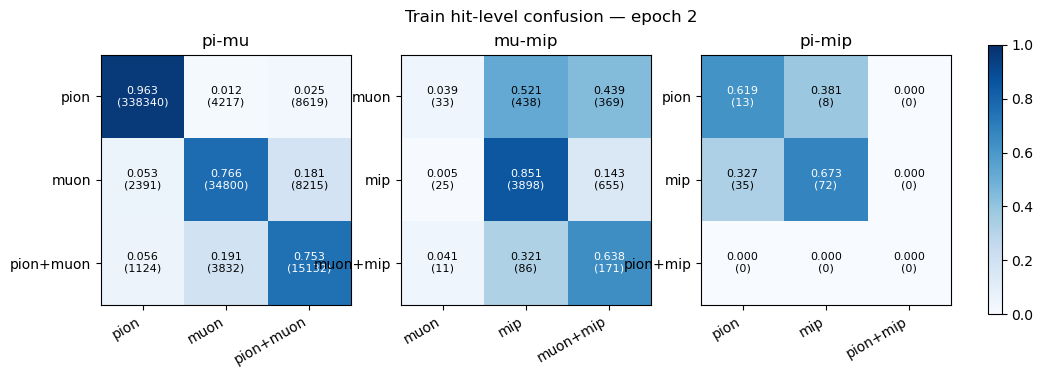

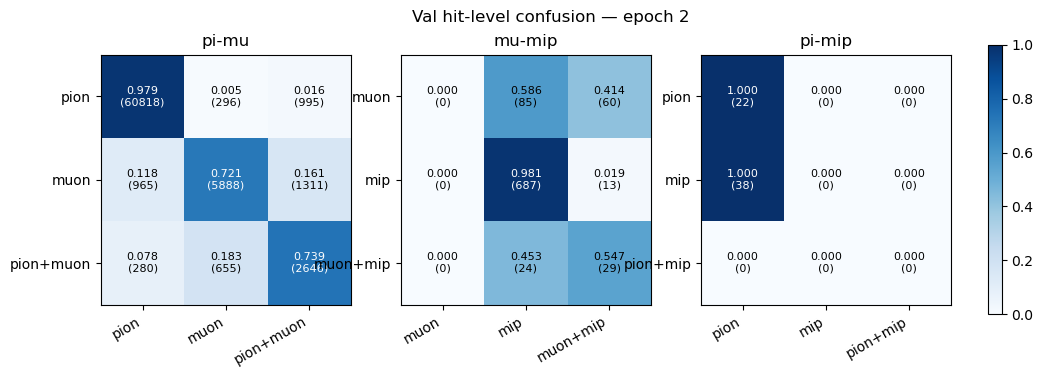

Epoch 03 | lr=0.00100 | train_loss=0.07105 acc=0.93952 | val_loss=0.06831 acc=0.94379


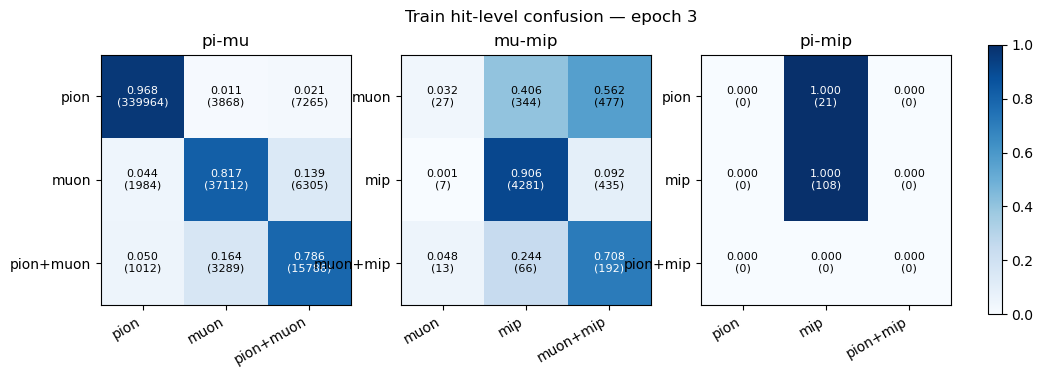

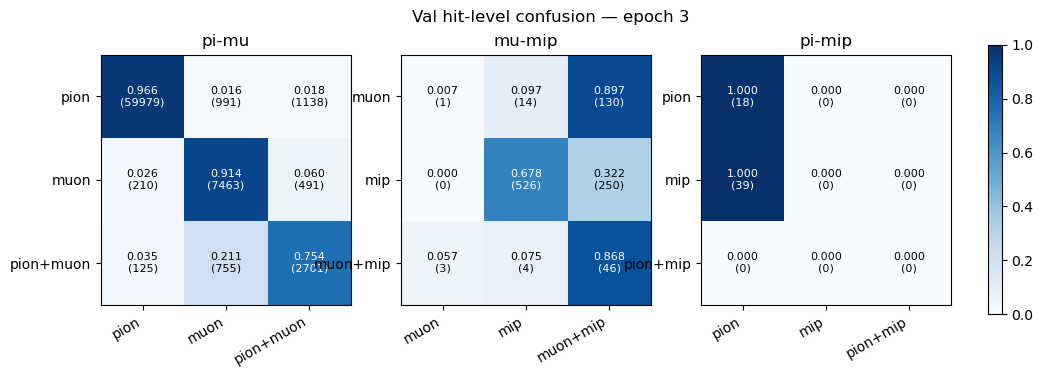

Epoch 04 | lr=0.00100 | train_loss=0.06132 acc=0.94880 | val_loss=0.05884 acc=0.95808


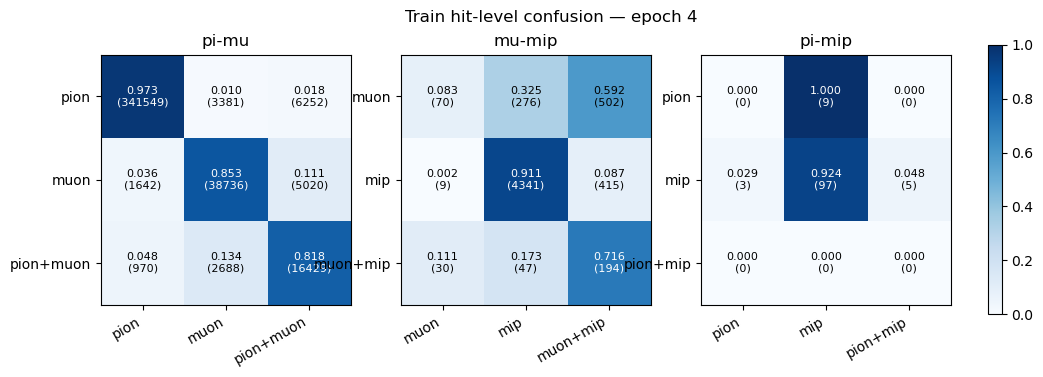

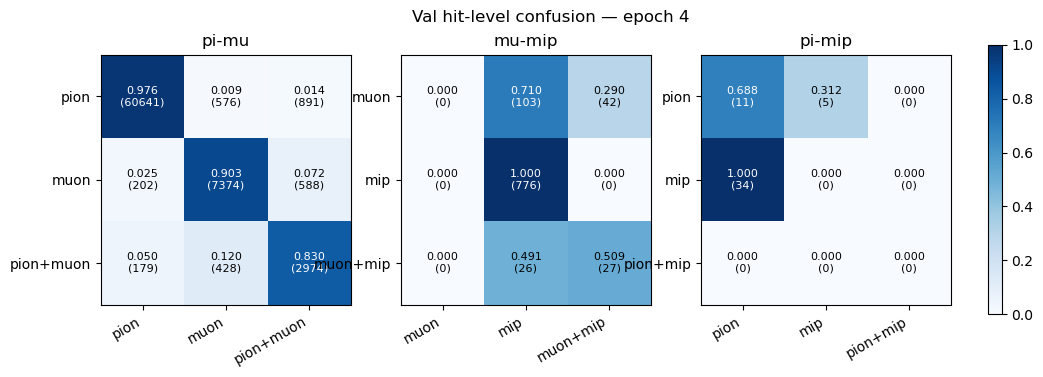

Epoch 05 | lr=0.00100 | train_loss=0.05298 acc=0.95644 | val_loss=0.04850 acc=0.96416


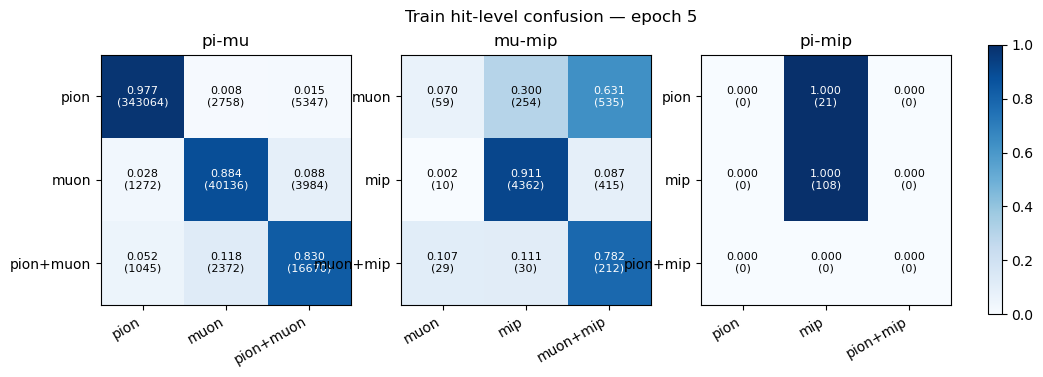

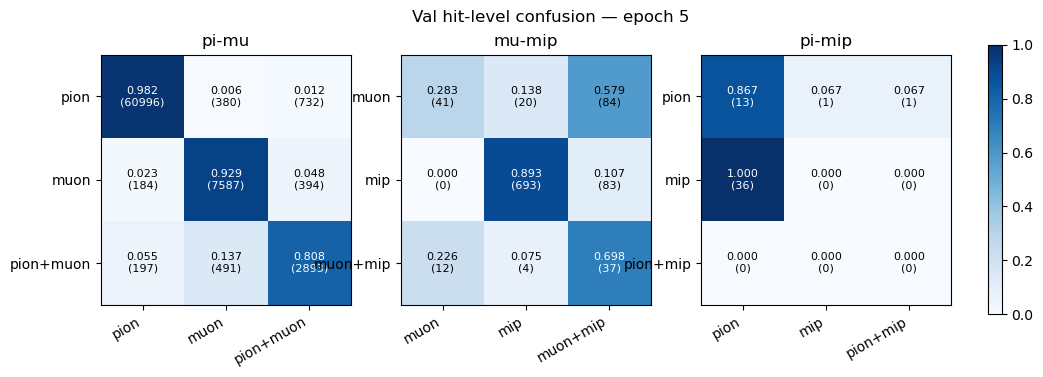

Epoch 06 | lr=0.00100 | train_loss=0.04432 acc=0.96526 | val_loss=0.03747 acc=0.96832


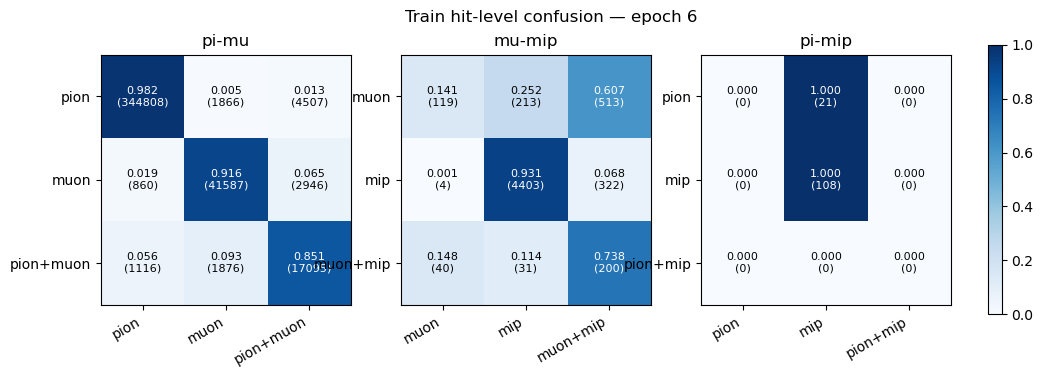

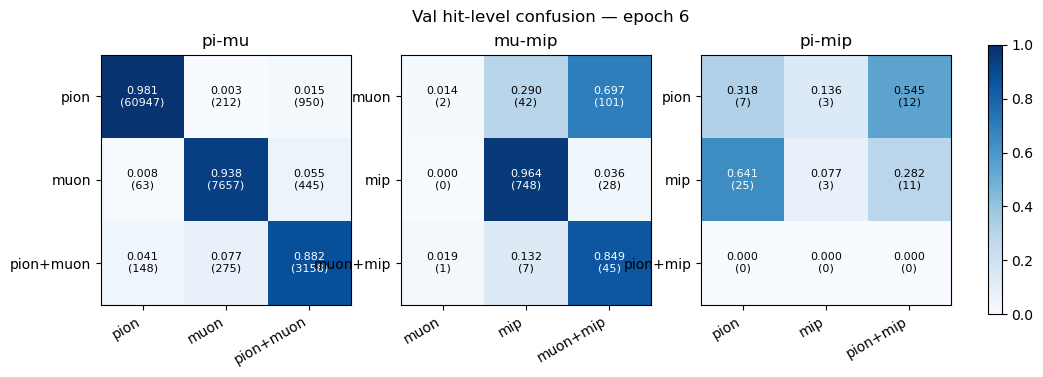

Epoch 07 | lr=0.00100 | train_loss=0.03901 acc=0.96887 | val_loss=0.03480 acc=0.97419


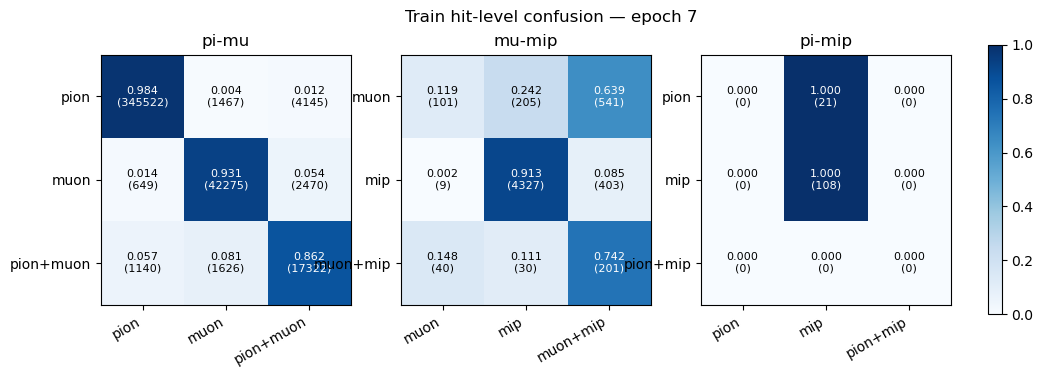

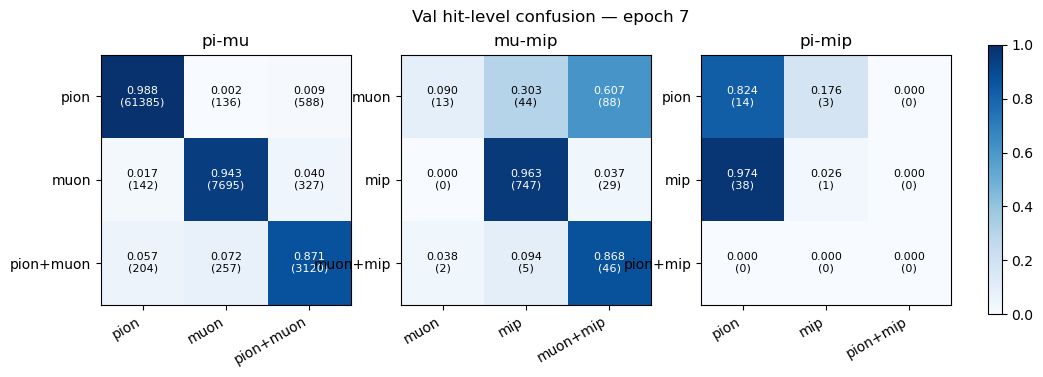

Epoch 08 | lr=0.00100 | train_loss=0.03548 acc=0.97214 | val_loss=0.03129 acc=0.97448


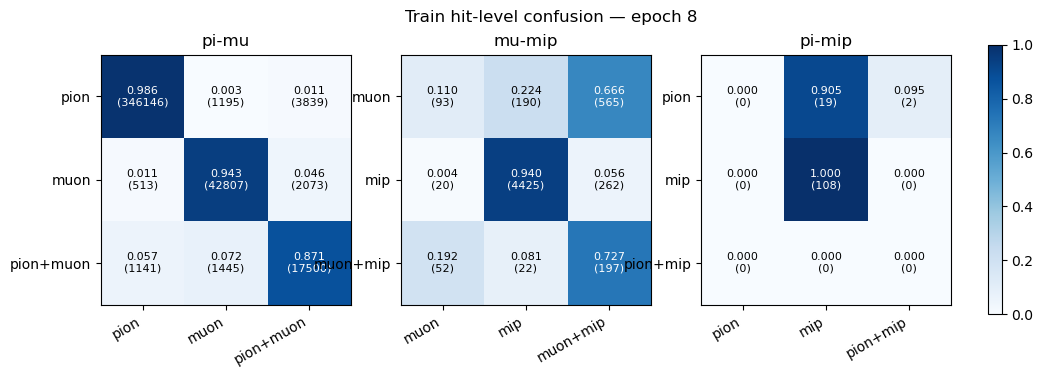

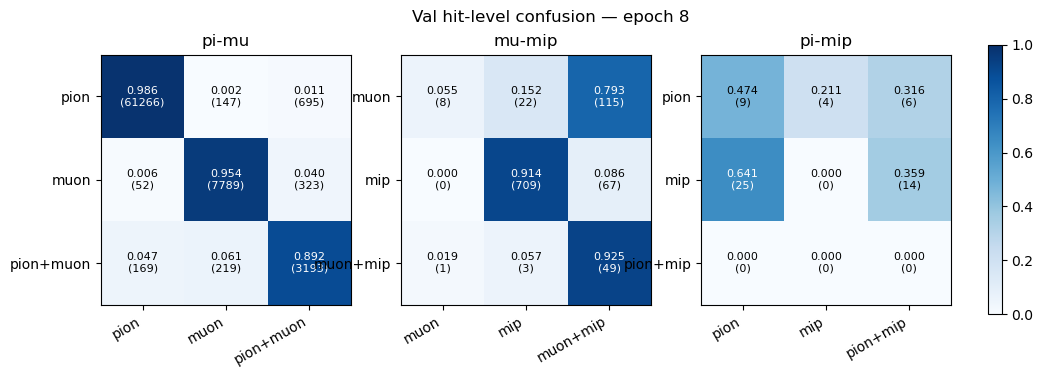

Epoch 09 | lr=0.00050 | train_loss=0.02942 acc=0.97661 | val_loss=0.02822 acc=0.97828


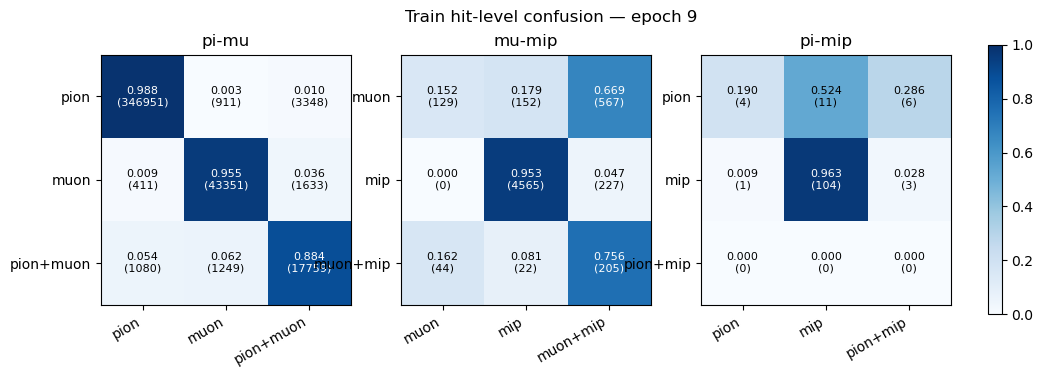

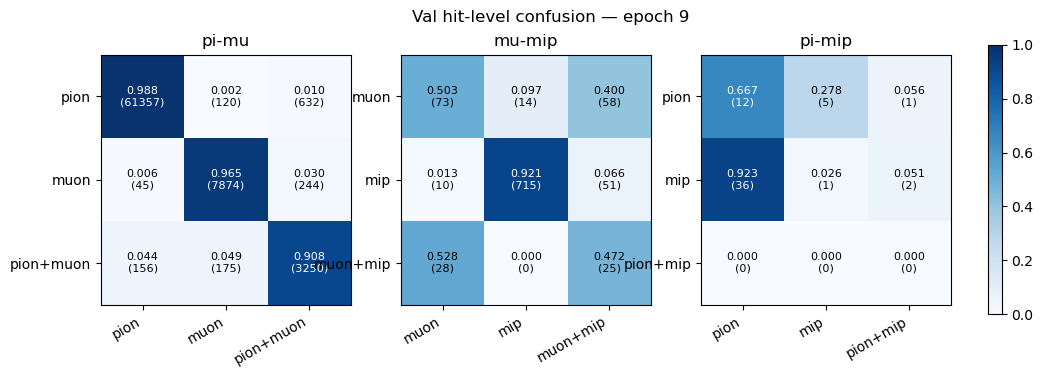

Epoch 10 | lr=0.00050 | train_loss=0.02841 acc=0.97721 | val_loss=0.02623 acc=0.97838


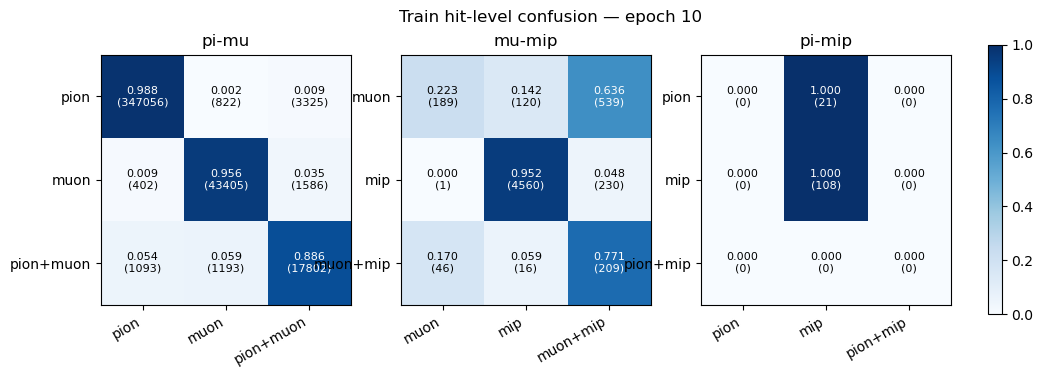

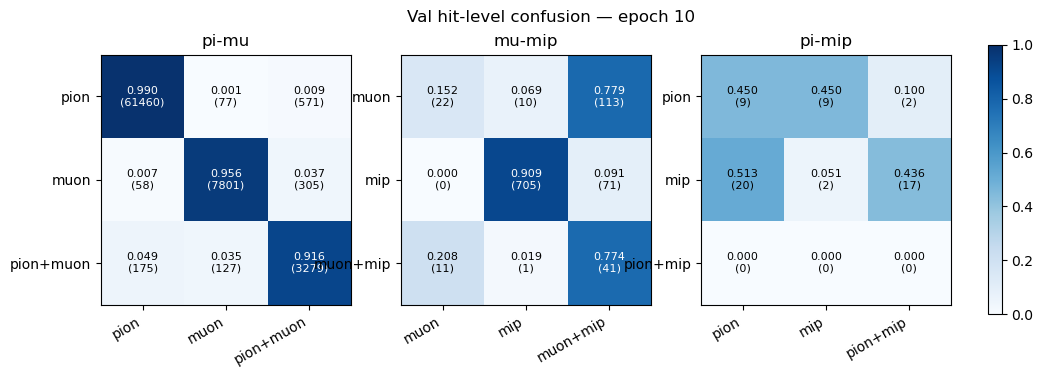

KeyboardInterrupt: 

In [20]:
FILE_PATTERN = '/mnt/e/testML/pimuTimeGroups/mainTimeGroups_*.npy'

# 1. Build splitter records from .npy chunks
#    Assumes load_splitter_groups now fills each record with:
#    - 'coord', 'z', 'energy', 'view'
#    - 'hit_labels' : [N, 3] -> [is_pi, is_mu, is_mip]
splitter_records = load_splitter_groups(
    FILE_PATTERN,
    max_files=20,
    limit_groups=1000000,
    min_hits=1,
)

# 2. Define the splitter model
#    in_dim depends on whether you use classifier probs or not:
#    - use_group_probs=False -> in_dim = 5  (coord, z, E, view, groupE)
#    - use_group_probs=True  -> in_dim = 8  (+ [p_pi, p_mu, p_mip])
splitter_model = GroupSplitter(
    hidden=150,
    heads=10,
    layers=3,
    dropout=0.15,
    # in_dim=5 or 8 if __init__ exposes this; otherwise keep default
)

# 3. Train the splitter
results = train_group_splitter(
    splitter_records,
    model=splitter_model,
    batch_size=5,
    epochs=50,
    lr=1e-3,
    weight_decay=1e-5,
    train_fraction=0.85,
    seed=13,
    grad_clip=2.0,
    scheduler_step_size=8,
    scheduler_gamma=0.5,
    # flip this to True when you've attached classifier outputs as 'group_probs'
    use_group_probs=False,
)

# 4. Inspect training statistics
#    We now have per-channel positive counts and pos_weight for BCE:
#    NODE_LABEL_TO_NAME should be {0: 'pion', 1: 'muon', 2: 'mip'}
label_names = [NODE_LABEL_TO_NAME[i] for i in range(len(NODE_LABEL_TO_NAME))]

print("Positive hit counts (train):",
      dict(zip(label_names, results['train_pos_counts'])))

print("Total train hits:", results['total_train_hits'])

print("pos_weight for BCE:",
      dict(zip(label_names, [round(w, 3) for w in results['pos_weight']])))
